# Grading Consistency Analysis

This notebook calculates **consistency scores** for graders based on how consistently they grade semantically equivalent programs.

**Consistency Score**: P(grading | program 1) == P(grading | program 2) given program 1 and program 2 are equivalent.

## Graders Analyzed:
- **Single-LLM**: Single LLM grading pass
- **Multi-LLM**: Adversarial grading (grader + critic + revision)
- **Maj-Vote**: Majority vote baseline (3 single-LLM grades, majority vote per category)
- **Human Graders**: Briana, Chen, Grace, Sanya, Shu

## Consistency Metrics:
1. **Total grading consistency**: Based on sum of all 4 categories (input + logic + syntax + print)
2. **Two-grade consistency**: Based on input + logic only
3. **Logic-only consistency**: Based only on the logic category

We also perform **qualitative error analysis** by extracting programs where each grader assigned inconsistent grades within semantic clusters.


In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
from itertools import combinations
from collections import defaultdict
from matplotlib.lines import Line2D


## 1. Load Data


In [37]:
# Load cluster data
cluster_df = pd.read_csv('results/analysis/cdg_cluster_batch1.csv')
print(f"Loaded {len(cluster_df)} clusters")
print(f"Columns: {cluster_df.columns.tolist()}")

# Load grading data (includes majority baseline)
grading_df = pd.read_csv('results/analysis/batch1_compiled_grading_maj.csv')
print(f"\nLoaded {len(grading_df)} grading records")
print(f"Columns: {grading_df.columns.tolist()}")


Loaded 34 clusters
Columns: ['Unnamed: 0', 'cluster_id', 'size', 'student_ids']

Loaded 100 grading records
Columns: ['student_id', 'code', 'initial_input', 'initial_logic', 'initial_syntax', 'initial_print', 'final_input', 'final_logic', 'final_syntax', 'final_print', 'briana_input', 'briana_logic', 'briana_syntax', 'briana_print', 'chen_input', 'chen_logic', 'chen_syntax', 'chen_print', 'grace_input', 'grace_logic', 'grace_syntax', 'grace_print', 'sanya_input', 'sanya_logic', 'sanya_syntax', 'sanya_print', 'shu_input', 'shu_logic', 'shu_syntax', 'shu_print', 'base_input', 'base_logic', 'base_print', 'base_syntax']


In [38]:
# Parse cluster student_ids (they are stored as string representations of lists)
def parse_student_ids(student_ids_str):
    """Parse the string representation of student_ids list."""
    try:
        return ast.literal_eval(student_ids_str)
    except:
        return []

cluster_df['student_ids_list'] = cluster_df['student_ids'].apply(parse_student_ids)

# Filter to clusters with 2+ programs (needed for consistency calculation)
multi_program_clusters = cluster_df[cluster_df['size'] >= 2].copy()
print(f"Clusters with 2+ programs: {len(multi_program_clusters)}")
print(f"Total programs in multi-program clusters: {multi_program_clusters['size'].sum()}")


Clusters with 2+ programs: 10
Total programs in multi-program clusters: 73


## 2. Define Graders and Categories


In [39]:
# Define graders
HUMAN_GRADERS = ['briana', 'chen', 'grace', 'sanya', 'shu']
AI_GRADERS = ['initial', 'final', 'base']  # initial = single LLM, final = multi LLM, base = majority vote
ALL_GRADERS = AI_GRADERS + HUMAN_GRADERS

# Define categories
CATEGORIES = ['input', 'logic', 'syntax', 'print']

# Create grader display names
GRADER_NAMES = {
    'initial': 'Single-LLM',
    'final': 'Multi-LLM',
    'base': 'Maj-Vote',
    'briana': 'Briana',
    'chen': 'Chen',
    'grace': 'Grace',
    'sanya': 'Sanya',
    'shu': 'Shu'
}

print(f"Graders: {ALL_GRADERS}")
print(f"Categories: {CATEGORIES}")


Graders: ['initial', 'final', 'base', 'briana', 'chen', 'grace', 'sanya', 'shu']
Categories: ['input', 'logic', 'syntax', 'print']


## 3. Calculate Consistency Scores


In [40]:
def get_total_grade(row, grader):
    """Get total grade (sum of all 4 categories) for a grader."""
    total = 0
    for cat in CATEGORIES:
        col = f"{grader}_{cat}"
        if col in row.index and pd.notna(row[col]):
            total += row[col]
    return total

def get_logic_grade(row, grader):
    """Get logic grade only for a grader."""
    col = f"{grader}_logic"
    if col in row.index and pd.notna(row[col]):
        return row[col]
    return None

def get_two_grade(row, grader):
    """Get sum of logic and input grades for a grader."""
    total = 0
    for cat in ['logic', 'input']:
        col = f"{grader}_{cat}"
        if col in row.index and pd.notna(row[col]):
            total += row[col]
        else:
            return None  # Return None if any category is missing
    return total

def calculate_consistency(grading_df, clusters_df, grader, grade_func):
    """
    Calculate consistency score for a grader.
    
    Consistency = (number of consistent pairs) / (total pairs)
    
    A pair is consistent if both programs in the pair have the same grade.
    """
    consistent_pairs = 0
    total_pairs = 0
    
    for _, cluster in clusters_df.iterrows():
        student_ids = cluster['student_ids_list']
        if len(student_ids) < 2:
            continue
        
        # Get grades for all students in this cluster
        grades = []
        for sid in student_ids:
            row = grading_df[grading_df['student_id'] == sid]
            if len(row) > 0:
                grade = grade_func(row.iloc[0], grader)
                if grade is not None:
                    grades.append(grade)
        
        # Count consistent pairs
        if len(grades) >= 2:
            for g1, g2 in combinations(grades, 2):
                total_pairs += 1
                if g1 == g2:
                    consistent_pairs += 1
    
    if total_pairs == 0:
        return 0.0, 0, 0
    
    consistency_score = consistent_pairs / total_pairs
    return consistency_score, consistent_pairs, total_pairs


In [41]:
# Calculate consistency scores for all graders
results = []

for grader in ALL_GRADERS:
    # Total grading consistency (all 4 categories)
    total_score, total_consistent, total_pairs = calculate_consistency(
        grading_df, multi_program_clusters, grader, get_total_grade
    )
    
    # Two-grade consistency (input + logic only)
    two_score, two_consistent, two_pairs = calculate_consistency(
        grading_df, multi_program_clusters, grader, get_two_grade
    )
    
    # Logic-only consistency
    logic_score, logic_consistent, logic_pairs = calculate_consistency(
        grading_df, multi_program_clusters, grader, get_logic_grade
    )
    
    results.append({
        'grader': grader,
        'display_name': GRADER_NAMES[grader],
        'total_consistency': total_score,
        'total_consistent_pairs': total_consistent,
        'total_pairs': total_pairs,
        'two_consistency': two_score,
        'two_consistent_pairs': two_consistent,
        'two_pairs': two_pairs,
        'logic_consistency': logic_score,
        'logic_consistent_pairs': logic_consistent,
        'logic_pairs': logic_pairs,
        'is_ai': grader in AI_GRADERS
    })

results_df = pd.DataFrame(results)
print("Consistency Scores:")
print(results_df[['display_name', 'total_consistency', 'two_consistency', 'logic_consistency', 'total_pairs']].to_string(index=False))


Consistency Scores:
display_name  total_consistency  two_consistency  logic_consistency  total_pairs
  Single-LLM           0.496799         0.736236           0.769526          781
   Multi-LLM           0.516005         0.934699           0.934699          781
    Maj-Vote           0.453265         0.734955           0.805378          781
      Briana           0.938540         0.983355           0.983355          781
        Chen           0.796415         0.966709           0.966709          781
       Grace           0.825864         0.868118           0.868118          781
       Sanya           0.737516         0.937260           0.983355          781
         Shu           0.530090         0.943662           0.943662          781


## 4. Detailed Results


In [42]:
print("="*70)
print("CONSISTENCY SCORE SUMMARY")
print("="*70)
print(f"\nBased on {multi_program_clusters['size'].sum()} programs in {len(multi_program_clusters)} clusters")
print(f"Total pairs compared: {results_df['total_pairs'].iloc[0]}")

print("\n" + "-"*70)
print("TOTAL GRADING CONSISTENCY (sum of input + logic + syntax + print)")
print("-"*70)
for _, row in results_df.sort_values('total_consistency', ascending=False).iterrows():
    grader_type = "AI" if row['is_ai'] else "Human"
    print(f"  {row['display_name']:12s} [{grader_type:5s}]: {row['total_consistency']:.3f} ({row['total_consistent_pairs']}/{row['total_pairs']} pairs)")

print("\n" + "-"*70)
print("TWO-GRADE CONSISTENCY (input + logic)")
print("-"*70)
for _, row in results_df.sort_values('two_consistency', ascending=False).iterrows():
    grader_type = "AI" if row['is_ai'] else "Human"
    print(f"  {row['display_name']:12s} [{grader_type:5s}]: {row['two_consistency']:.3f} ({row['two_consistent_pairs']}/{row['two_pairs']} pairs)")

print("\n" + "-"*70)
print("LOGIC-ONLY CONSISTENCY")
print("-"*70)
for _, row in results_df.sort_values('logic_consistency', ascending=False).iterrows():
    grader_type = "AI" if row['is_ai'] else "Human"
    print(f"  {row['display_name']:12s} [{grader_type:5s}]: {row['logic_consistency']:.3f} ({row['logic_consistent_pairs']}/{row['logic_pairs']} pairs)")

# Summary statistics
print("\n" + "-"*70)
print("SUMMARY STATISTICS")
print("-"*70)

ai_results = results_df[results_df['is_ai']]
human_results = results_df[~results_df['is_ai']]

print(f"\nTotal Grading Consistency:")
print(f"  AI Graders Mean:    {ai_results['total_consistency'].mean():.3f}")
print(f"  Human Graders Mean: {human_results['total_consistency'].mean():.3f}")

print(f"\nTwo-Grade Consistency (input + logic):")
print(f"  AI Graders Mean:    {ai_results['two_consistency'].mean():.3f}")
print(f"  Human Graders Mean: {human_results['two_consistency'].mean():.3f}")

print(f"\nLogic-Only Consistency:")
print(f"  AI Graders Mean:    {ai_results['logic_consistency'].mean():.3f}")
print(f"  Human Graders Mean: {human_results['logic_consistency'].mean():.3f}")


CONSISTENCY SCORE SUMMARY

Based on 73 programs in 10 clusters
Total pairs compared: 781

----------------------------------------------------------------------
TOTAL GRADING CONSISTENCY (sum of input + logic + syntax + print)
----------------------------------------------------------------------
  Briana       [Human]: 0.939 (733/781 pairs)
  Grace        [Human]: 0.826 (645/781 pairs)
  Chen         [Human]: 0.796 (622/781 pairs)
  Sanya        [Human]: 0.738 (576/781 pairs)
  Shu          [Human]: 0.530 (414/781 pairs)
  Multi-LLM    [AI   ]: 0.516 (403/781 pairs)
  Single-LLM   [AI   ]: 0.497 (388/781 pairs)
  Maj-Vote     [AI   ]: 0.453 (354/781 pairs)

----------------------------------------------------------------------
TWO-GRADE CONSISTENCY (input + logic)
----------------------------------------------------------------------
  Briana       [Human]: 0.983 (768/781 pairs)
  Chen         [Human]: 0.967 (755/781 pairs)
  Shu          [Human]: 0.944 (737/781 pairs)
  Sanya        

## 5. Visualization - Dot Plot


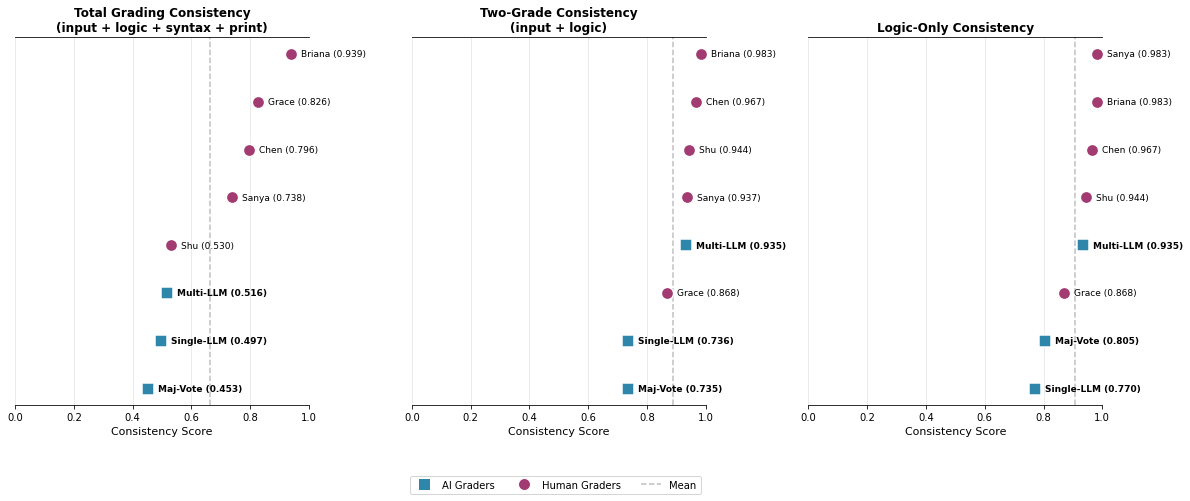


✅ Plot saved to results/analysis/consistency_scores.png


In [43]:
# Set up the figure with three subplots - wider to accommodate labels outside plot area
fig, axes = plt.subplots(1, 3, figsize=(20, 7))  # Increased height for 8 graders

# Colors
ai_color = '#2E86AB'      # Blue for AI
human_color = '#A23B72'   # Purple for humans

# Sort by consistency score for better visualization
results_sorted_total = results_df.sort_values('total_consistency', ascending=True)
results_sorted_two = results_df.sort_values('two_consistency', ascending=True)
results_sorted_logic = results_df.sort_values('logic_consistency', ascending=True)

# --- Plot 1: Total Grading Consistency ---
ax1 = axes[0]
y_positions = range(len(results_sorted_total))

for i, (_, row) in enumerate(results_sorted_total.iterrows()):
    color = ai_color if row['is_ai'] else human_color
    marker = 's' if row['is_ai'] else 'o'  # Square for AI, circle for human
    ax1.scatter(row['total_consistency'], i, c=color, s=150, marker=marker, 
                edgecolors='white', linewidths=1.5, zorder=3)
    # Add grader name label beside the dot (to the right), clip_on=False allows text outside axes
    ax1.annotate(f"{row['display_name']} ({row['total_consistency']:.3f})", 
                 xy=(row['total_consistency'], i),
                 xytext=(10, 0), textcoords='offset points',
                 fontsize=9, va='center', fontweight='bold' if row['is_ai'] else 'normal',
                 clip_on=False)

ax1.set_yticks([])  # Remove y-axis ticks since labels are beside dots
ax1.set_xlabel('Consistency Score', fontsize=11)
ax1.set_title('Total Grading Consistency\n(input + logic + syntax + print)', fontsize=12, fontweight='bold')
ax1.set_xlim(0, 1)  # Standard 0-1 range for probability
ax1.axvline(x=results_df['total_consistency'].mean(), color='gray', linestyle='--', alpha=0.5, label='Mean')
ax1.grid(axis='x', alpha=0.3)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)

# --- Plot 2: Two-Grade Consistency ---
ax2 = axes[1]

for i, (_, row) in enumerate(results_sorted_two.iterrows()):
    color = ai_color if row['is_ai'] else human_color
    marker = 's' if row['is_ai'] else 'o'
    ax2.scatter(row['two_consistency'], i, c=color, s=150, marker=marker,
                edgecolors='white', linewidths=1.5, zorder=3)
    ax2.annotate(f"{row['display_name']} ({row['two_consistency']:.3f})", 
                 xy=(row['two_consistency'], i),
                 xytext=(10, 0), textcoords='offset points',
                 fontsize=9, va='center', fontweight='bold' if row['is_ai'] else 'normal',
                 clip_on=False)

ax2.set_yticks([])
ax2.set_xlabel('Consistency Score', fontsize=11)
ax2.set_title('Two-Grade Consistency\n(input + logic)', fontsize=12, fontweight='bold')
ax2.set_xlim(0, 1)
ax2.axvline(x=results_df['two_consistency'].mean(), color='gray', linestyle='--', alpha=0.5, label='Mean')
ax2.grid(axis='x', alpha=0.3)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)

# --- Plot 3: Logic-Only Consistency ---
ax3 = axes[2]

for i, (_, row) in enumerate(results_sorted_logic.iterrows()):
    color = ai_color if row['is_ai'] else human_color
    marker = 's' if row['is_ai'] else 'o'
    ax3.scatter(row['logic_consistency'], i, c=color, s=150, marker=marker,
                edgecolors='white', linewidths=1.5, zorder=3)
    ax3.annotate(f"{row['display_name']} ({row['logic_consistency']:.3f})", 
                 xy=(row['logic_consistency'], i),
                 xytext=(10, 0), textcoords='offset points',
                 fontsize=9, va='center', fontweight='bold' if row['is_ai'] else 'normal',
                 clip_on=False)

ax3.set_yticks([])
ax3.set_xlabel('Consistency Score', fontsize=11)
ax3.set_title('Logic-Only Consistency', fontsize=12, fontweight='bold')
ax3.set_xlim(0, 1)
ax3.axvline(x=results_df['logic_consistency'].mean(), color='gray', linestyle='--', alpha=0.5, label='Mean')
ax3.grid(axis='x', alpha=0.3)
ax3.spines['right'].set_visible(False)
ax3.spines['left'].set_visible(False)

# Add legend
legend_elements = [
    Line2D([0], [0], marker='s', color='w', markerfacecolor=ai_color, markersize=12, label='AI Graders'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=human_color, markersize=12, label='Human Graders'),
    Line2D([0], [0], color='gray', linestyle='--', alpha=0.5, label='Mean')
]
fig.legend(handles=legend_elements, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 0.02))

# Adjust subplot spacing to leave room for annotations on the right
plt.subplots_adjust(bottom=0.15, right=0.88, wspace=0.35)
plt.savefig('results/analysis/consistency_scores.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Plot saved to results/analysis/consistency_scores.png")


## 6. Combined Dot Plot


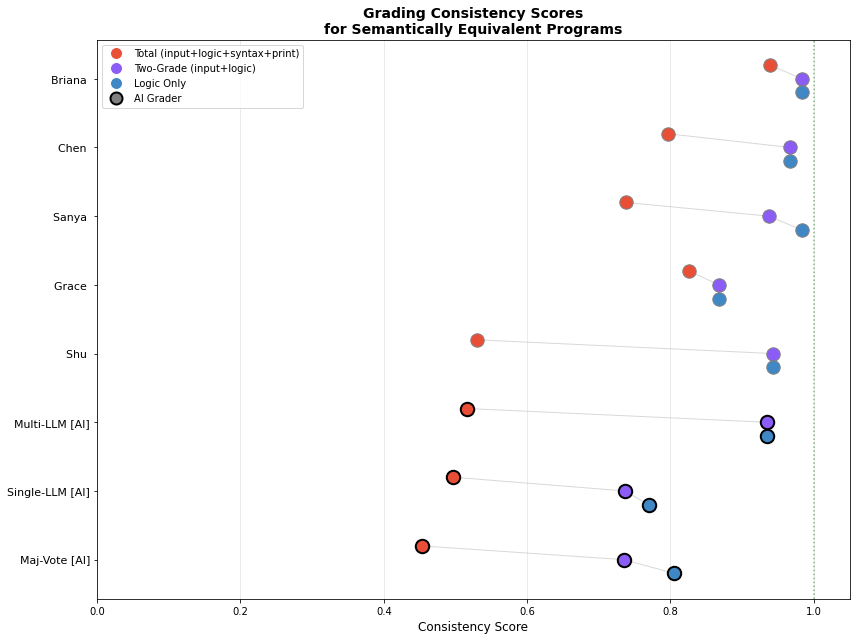


✅ Combined plot saved to results/analysis/consistency_scores_combined.png


In [44]:
# Create a combined dot plot with all three metrics for each grader
fig, ax = plt.subplots(figsize=(12, 9))  # Increased height for 8 graders

# Sort by average of all three scores
results_df['avg_consistency'] = (results_df['total_consistency'] + results_df['two_consistency'] + results_df['logic_consistency']) / 3
results_sorted = results_df.sort_values('avg_consistency', ascending=True)

y_positions = np.arange(len(results_sorted))
offset = 0.2  # Offset for the three dots

# Colors for metrics
total_color = '#E94F37'  # Red-orange for total
two_color = '#8B5CF6'    # Purple for two-grade
logic_color = '#3F88C5'  # Blue for logic

for i, (_, row) in enumerate(results_sorted.iterrows()):
    # Marker based on AI/human
    edge_color = 'black' if row['is_ai'] else 'gray'
    edge_width = 2 if row['is_ai'] else 1
    
    # Total consistency (upper dot)
    ax.scatter(row['total_consistency'], i + offset, c=total_color, s=180, 
               marker='o', edgecolors=edge_color, linewidths=edge_width, zorder=3)
    
    # Two-grade consistency (middle dot)
    ax.scatter(row['two_consistency'], i, c=two_color, s=180,
               marker='o', edgecolors=edge_color, linewidths=edge_width, zorder=3)
    
    # Logic consistency (lower dot)
    ax.scatter(row['logic_consistency'], i - offset, c=logic_color, s=180,
               marker='o', edgecolors=edge_color, linewidths=edge_width, zorder=3)
    
    # Connect the dots with lines
    ax.plot([row['total_consistency'], row['two_consistency'], row['logic_consistency']], 
            [i + offset, i, i - offset], color='gray', alpha=0.3, linewidth=1, zorder=1)

# Formatting
ax.set_yticks(y_positions)
ax.set_yticklabels([f"{row['display_name']} {'[AI]' if row['is_ai'] else ''}" 
                    for _, row in results_sorted.iterrows()], fontsize=11)
ax.set_xlabel('Consistency Score', fontsize=12)
ax.set_title('Grading Consistency Scores\nfor Semantically Equivalent Programs', fontsize=14, fontweight='bold')
ax.set_xlim(0, 1.05)
ax.grid(axis='x', alpha=0.3)

# Add vertical line at perfect consistency
ax.axvline(x=1.0, color='green', linestyle=':', alpha=0.5, label='Perfect Consistency')

# Legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=total_color, markersize=12, 
           label='Total (input+logic+syntax+print)'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=two_color, markersize=12, 
           label='Two-Grade (input+logic)'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=logic_color, markersize=12, 
           label='Logic Only'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=12,
           markeredgecolor='black', markeredgewidth=2, label='AI Grader'),
]
ax.legend(handles=legend_elements, loc='upper left', fontsize=10)

plt.tight_layout()
plt.savefig('results/analysis/consistency_scores_combined.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Combined plot saved to results/analysis/consistency_scores_combined.png")


## 7. Save Results


In [45]:
# Save results to CSV
results_df.to_csv('results/analysis/consistency_scores.csv', index=False)
print("✅ Results saved to results/analysis/consistency_scores.csv")

# Display final summary
print("\n" + "="*70)
print("FINAL SUMMARY")
print("="*70)
print(f"\nConsistency Score = P(same grade | equivalent programs)")
print(f"\nHigher score = more consistent grading for equivalent programs")
print(f"\nBest Total Consistency: {results_df.loc[results_df['total_consistency'].idxmax(), 'display_name']} ({results_df['total_consistency'].max():.3f})")
print(f"Best Two-Grade Consistency: {results_df.loc[results_df['two_consistency'].idxmax(), 'display_name']} ({results_df['two_consistency'].max():.3f})")
print(f"Best Logic Consistency: {results_df.loc[results_df['logic_consistency'].idxmax(), 'display_name']} ({results_df['logic_consistency'].max():.3f})")


✅ Results saved to results/analysis/consistency_scores.csv

FINAL SUMMARY

Consistency Score = P(same grade | equivalent programs)

Higher score = more consistent grading for equivalent programs

Best Total Consistency: Briana (0.939)
Best Two-Grade Consistency: Briana (0.983)
Best Logic Consistency: Briana (0.983)


## 8. Qualitative Error Analysis - Inconsistent Programs per Grader

For each **grader**, we:
1. Calculate the **reference grade** (majority vote) for each category within each cluster
2. Extract programs where that grader's score differs from their own reference in **any category**
3. Save results to individual CSV files per grader

This approach identifies which programs contribute to each grader's consistency score, enabling targeted qualitative analysis.

In [46]:
from statistics import mode, StatisticsError

def get_majority_grade(grades_list):
    """Get the majority (mode) grade from a list of grades."""
    if not grades_list:
        return None
    try:
        return mode(grades_list)
    except StatisticsError:
        # If no unique mode, use median
        return sorted(grades_list)[len(grades_list)//2]

def extract_inconsistent_programs_for_grader(grading_df, clusters_df, grader):
    """
    For a specific grader, extract programs where their grade differs from 
    their own reference (majority vote) in ANY category within each cluster.
    
    Returns a DataFrame with:
    - cluster_id
    - student_id
    - code
    - input, logic, syntax, print (grader's scores)
    - ref_input, ref_logic, ref_syntax, ref_print (reference scores)
    - inconsistent_categories (which categories differed)
    """
    inconsistent_records = []
    
    for _, cluster in clusters_df.iterrows():
        cluster_id = cluster['cluster_id']
        student_ids = cluster['student_ids_list']
        
        if len(student_ids) < 2:
            continue
        
        # Collect grades for this grader for all programs in cluster
        category_grades = {cat: [] for cat in CATEGORIES}  # {category: [grades]}
        program_data = {}  # student_id -> {category: grade, 'code': code}
        
        for sid in student_ids:
            row = grading_df[grading_df['student_id'] == sid]
            if len(row) == 0:
                continue
            row = row.iloc[0]
            program_data[sid] = {'code': row['code']}
            
            for cat in CATEGORIES:
                col = f"{grader}_{cat}"
                if col in row.index and pd.notna(row[col]):
                    grade = row[col]
                    program_data[sid][cat] = grade
                    category_grades[cat].append(grade)
        
        # Calculate reference grade for each category (majority vote for THIS grader)
        ref_grades = {}
        for cat in CATEGORIES:
            ref_grades[cat] = get_majority_grade(category_grades[cat])
        
        # Find programs where grader differs from their reference in any category
        for sid, data in program_data.items():
            inconsistent_cats = []
            for cat in CATEGORIES:
                if cat in data and ref_grades[cat] is not None:
                    if data[cat] != ref_grades[cat]:
                        inconsistent_cats.append(cat)
            
            # Only include if at least one category is inconsistent
            if inconsistent_cats:
                record = {
                    'cluster_id': cluster_id,
                    'student_id': sid,
                    'code': data['code'],
                    'input': data.get('input', None),
                    'logic': data.get('logic', None),
                    'syntax': data.get('syntax', None),
                    'print': data.get('print', None),
                    'ref_input': ref_grades.get('input', None),
                    'ref_logic': ref_grades.get('logic', None),
                    'ref_syntax': ref_grades.get('syntax', None),
                    'ref_print': ref_grades.get('print', None),
                    'inconsistent_categories': ', '.join(inconsistent_cats)
                }
                inconsistent_records.append(record)
    
    return pd.DataFrame(inconsistent_records)

# Extract inconsistent programs for each grader
grader_inconsistencies = {}
print("="*70)
print("EXTRACTING INCONSISTENT PROGRAMS PER GRADER")
print("="*70)

for grader in ALL_GRADERS:
    df = extract_inconsistent_programs_for_grader(grading_df, multi_program_clusters, grader)
    grader_inconsistencies[grader] = df
    print(f"{GRADER_NAMES[grader]:12s}: {len(df):3d} inconsistent programs")

EXTRACTING INCONSISTENT PROGRAMS PER GRADER
Single-LLM  :  30 inconsistent programs
Multi-LLM   :  24 inconsistent programs
Maj-Vote    :  29 inconsistent programs
Briana      :   3 inconsistent programs
Chen        :  10 inconsistent programs
Grace       :  12 inconsistent programs
Sanya       :   9 inconsistent programs
Shu         :  20 inconsistent programs


In [47]:
# Detailed breakdown by category for each grader
print("="*70)
print("INCONSISTENCY BREAKDOWN BY CATEGORY")
print("="*70)

for grader in ALL_GRADERS:
    df = grader_inconsistencies[grader]
    if len(df) == 0:
        print(f"\n{GRADER_NAMES[grader]}: No inconsistencies")
        continue
    
    # Count inconsistencies by category
    cat_counts = {cat: 0 for cat in CATEGORIES}
    for _, row in df.iterrows():
        for cat in row['inconsistent_categories'].split(', '):
            if cat in cat_counts:
                cat_counts[cat] += 1
    
    print(f"\n{GRADER_NAMES[grader]} ({len(df)} programs with inconsistencies):")
    for cat, count in cat_counts.items():
        if count > 0:
            print(f"  - {cat}: {count} programs")

INCONSISTENCY BREAKDOWN BY CATEGORY

Single-LLM (30 programs with inconsistencies):
  - input: 2 programs
  - logic: 8 programs
  - syntax: 2 programs
  - print: 24 programs

Multi-LLM (24 programs with inconsistencies):
  - input: 1 programs
  - logic: 5 programs
  - syntax: 1 programs
  - print: 23 programs

Maj-Vote (29 programs with inconsistencies):
  - input: 4 programs
  - logic: 7 programs
  - syntax: 2 programs
  - print: 25 programs

Briana (3 programs with inconsistencies):
  - input: 1 programs
  - logic: 2 programs
  - syntax: 3 programs
  - print: 1 programs

Chen (10 programs with inconsistencies):
  - input: 1 programs
  - logic: 5 programs
  - syntax: 1 programs
  - print: 6 programs

Grace (12 programs with inconsistencies):
  - input: 1 programs
  - logic: 10 programs
  - syntax: 1 programs
  - print: 3 programs

Sanya (9 programs with inconsistencies):
  - input: 2 programs
  - logic: 2 programs
  - syntax: 8 programs
  - print: 2 programs

Shu (20 programs with inc

In [48]:
# Show sample of inconsistent programs for AI graders (most interesting)
print("="*70)
print("SAMPLE INCONSISTENT PROGRAMS - AI GRADERS")
print("="*70)

for grader in AI_GRADERS:
    df = grader_inconsistencies[grader]
    if len(df) == 0:
        continue
    
    print(f"\n{'='*70}")
    print(f"{GRADER_NAMES[grader]} - First 3 Inconsistent Programs")
    print(f"{'='*70}")
    
    for idx, (_, row) in enumerate(df.head(3).iterrows()):
        print(f"\n📝 [{idx+1}] Cluster {row['cluster_id']}, Student: {row['student_id']}")
        print(f"   Inconsistent categories: {row['inconsistent_categories']}")
        print(f"   Grades:  input={row['input']} (ref={row['ref_input']}), "
              f"logic={row['logic']} (ref={row['ref_logic']}), "
              f"syntax={row['syntax']} (ref={row['ref_syntax']}), "
              f"print={row['print']} (ref={row['ref_print']})")
        
        # Show first 200 chars of code as preview
        code_preview = row['code'][:200].replace('\n', ' ') + "..."
        print(f"   Code preview: {code_preview}")

SAMPLE INCONSISTENT PROGRAMS - AI GRADERS

Single-LLM - First 3 Inconsistent Programs

📝 [1] Cluster 1, Student: z7YmEH6s4Hag7flPAvJ1xQoCB5H2
   Inconsistent categories: print
   Grades:  input=0 (ref=0), logic=0 (ref=0), syntax=0 (ref=0), print=1 (ref=0)
   Code preview: def main(): #First, we are gonna ask the user their heights in meters.     height_str=input("Enter your height in meters")     height=float(height_str)      if height > 1.6 and height < 1.9:         p...

📝 [2] Cluster 1, Student: bvYuTX2QtIf5PM1Wrbuk20wPVko1
   Inconsistent categories: logic
   Grades:  input=0 (ref=0), logic=1 (ref=0), syntax=0 (ref=0), print=0 (ref=0)
   Code preview: def main():     # TODO write your solution here     h=float(input("Enter your height in meters: "))     if h>1.6 and h<1.9:         print("Correct height to be an astronaut")     if h<=1.6:         pr...

📝 [3] Cluster 1, Student: asf1t44qDJQ2yBQxAvpnYO9OrDy2
   Inconsistent categories: print
   Grades:  input=0 (ref=0), logic=0 (ref=

In [49]:
# Save inconsistent programs to individual CSV files per grader
import os

# Create output directory if needed
output_dir = 'results/analysis/inconsistent_programs'
os.makedirs(output_dir, exist_ok=True)

print("="*70)
print("SAVING INCONSISTENT PROGRAMS TO CSV FILES")
print("="*70)

# Define columns for output
output_columns = ['cluster_id', 'student_id', 'code', 'input', 'logic', 'syntax', 'print',
                  'ref_input', 'ref_logic', 'ref_syntax', 'ref_print', 'inconsistent_categories']

for grader in ALL_GRADERS:
    df = grader_inconsistencies[grader]
    
    # Use grader key for filename
    filename = f"{output_dir}/{grader}_inconsistent.csv"
    
    if len(df) > 0:
        df[output_columns].to_csv(filename, index=False)
        print(f"✅ {GRADER_NAMES[grader]:12s}: Saved {len(df):3d} programs to {filename}")
    else:
        # Create empty file with headers
        pd.DataFrame(columns=output_columns).to_csv(filename, index=False)
        print(f"✅ {GRADER_NAMES[grader]:12s}: No inconsistencies (empty file created)")

print(f"\n📁 All files saved to: {output_dir}/")

SAVING INCONSISTENT PROGRAMS TO CSV FILES
✅ Single-LLM  : Saved  30 programs to results/analysis/inconsistent_programs/initial_inconsistent.csv
✅ Multi-LLM   : Saved  24 programs to results/analysis/inconsistent_programs/final_inconsistent.csv
✅ Maj-Vote    : Saved  29 programs to results/analysis/inconsistent_programs/base_inconsistent.csv
✅ Briana      : Saved   3 programs to results/analysis/inconsistent_programs/briana_inconsistent.csv
✅ Chen        : Saved  10 programs to results/analysis/inconsistent_programs/chen_inconsistent.csv
✅ Grace       : Saved  12 programs to results/analysis/inconsistent_programs/grace_inconsistent.csv
✅ Sanya       : Saved   9 programs to results/analysis/inconsistent_programs/sanya_inconsistent.csv
✅ Shu         : Saved  20 programs to results/analysis/inconsistent_programs/shu_inconsistent.csv

📁 All files saved to: results/analysis/inconsistent_programs/


In [50]:
# Summary of qualitative error analysis
print("="*70)
print("QUALITATIVE ERROR ANALYSIS SUMMARY")
print("="*70)

print("\nFor each grader, we extracted programs where their score differs from")
print("their own majority vote (reference) within each semantic cluster.")
print("\nThis identifies the exact programs that contribute to inconsistency,")
print("enabling targeted qualitative review.")

print("\n" + "-"*70)
print("GRADER INCONSISTENCY SUMMARY")
print("-"*70)
print(f"\n{'Grader':<15} {'Programs':<12} {'Type':<8} {'Consistency Score'}")
print("-"*55)

for grader in ALL_GRADERS:
    count = len(grader_inconsistencies[grader])
    grader_type = "AI" if grader in AI_GRADERS else "Human"
    consistency = results_df[results_df['grader'] == grader]['total_consistency'].values[0]
    print(f"{GRADER_NAMES[grader]:<15} {count:<12} {grader_type:<8} {consistency:.3f}")

# Total by type
ai_count = sum(len(grader_inconsistencies[g]) for g in AI_GRADERS)
human_count = sum(len(grader_inconsistencies[g]) for g in HUMAN_GRADERS)
print(f"\nTotal AI grader inconsistent programs: {ai_count}")
print(f"Total Human grader inconsistent programs: {human_count}")

QUALITATIVE ERROR ANALYSIS SUMMARY

For each grader, we extracted programs where their score differs from
their own majority vote (reference) within each semantic cluster.

This identifies the exact programs that contribute to inconsistency,
enabling targeted qualitative review.

----------------------------------------------------------------------
GRADER INCONSISTENCY SUMMARY
----------------------------------------------------------------------

Grader          Programs     Type     Consistency Score
-------------------------------------------------------
Single-LLM      30           AI       0.497
Multi-LLM       24           AI       0.516
Maj-Vote        29           AI       0.453
Briana          3            Human    0.939
Chen            10           Human    0.796
Grace           12           Human    0.826
Sanya           9            Human    0.738
Shu             20           Human    0.530

Total AI grader inconsistent programs: 83
Total Human grader inconsistent programs